In [4]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from warnings import filterwarnings

filterwarnings('ignore')

from modules.data_fetcher import download_historical_data

In [7]:
SYMBOL= 'BTC-USDT'

df = download_historical_data(SYMBOL,'1hour').iloc[-3000:]
df["Return"] = df.Close.pct_change()
df.dropna(inplace=True)
print(df.shape)
df.head()

(2999, 8)


,Timestamp,Open,Close,High,Low,Amount,Volume,Return
Date,,,,,,,,
2022-10-25 10:00:00,1.666685e+09,19306.7,19295.5,19323.5,19269.6,281.055517,5.425897e+06,-0.000554
2022-10-25 11:00:00,1.666688e+09,19295.4,19266.3,19296.1,19257.0,291.026014,5.610201e+06,-0.001513
2022-10-25 12:00:00,1.666692e+09,19266.3,19296.2,19298.9,19237.5,259.489626,5.001039e+06,0.001552
2022-10-25 13:00:00,1.666696e+09,19296.4,19301.3,19328.9,19275.6,205.836094,3.972412e+06,0.000264
2022-10-25 14:00:00,1.666699e+09,19301.3,19325.5,19343.7,19260.0,297.347957,5.737919e+06,0.001254


# Fourrier Tranformation

## Detrend

In [9]:
df['Trend'] = seasonal_decompose(df.Close,model='additive',extrapolate_trend='freq').trend
df['Detrended_close'] = df['Close']-df['Trend']
fig = make_subplots(
    rows=2, cols=1, subplot_titles=("Raw signal","Detrended")
)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Detrended data",
         x=df.index,
         y=df["Detrended_close"],
    ),
    row=2,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Detrenting data",
)

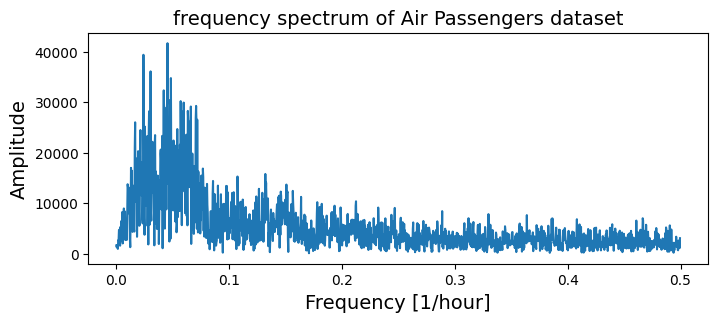

In [15]:

import matplotlib.pyplot as plt

def construct_fft(yvalues,real_abs_only:bool=True):
    N = len(yvalues)
    fft_y = np.fft.fft(yvalues)
    fft_x = np.fft.fftfreq(N)
    if real_abs_only:
        fft_x = fft_x[:len(fft_x)//2]
        fft_y = np.abs(fft_y[:len(fft_y)//2])
    return fft_x, fft_y


yvalues = df['Detrended_close'].values
fft_x, fft_y = construct_fft(yvalues,)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(fft_x, fft_y)
ax.set_title('frequency spectrum of The Detrented Close', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_xlabel('Frequency [1/hour]', fontsize=14)
plt.show()

# Smoothing (Low pass filter)

In [16]:
 
def fft_denoiser(x:np.array, n_components:float=10)-> np.array:
    """Fast fourier transform denoiser (low pass filter)

    Args:
        x (np.array): The data to denoise.
        n_components (float, optional): The value above which the coefficients will be kept. Defaults to 0.0005.

    Returns:
        np.array: The denoised data. 
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep low frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
        
    return clean_data.real

In [19]:
df['Close_denoised'] = fft_denoiser(df.Close.values, n_components=100000)

In [20]:
fig = make_subplots(
    rows=1, cols=1# , subplot_titles=("Fourrier and raw data comparing")
)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Denoised data",
         x=df.index,
         y=df["Close_denoised"],
    ),
    row=1,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Fourrier extrapolation (prediction)",
)